

<h1 align=center><font size = 10>IBM CAPSTONE PROJECT</font></h1>

## Introduction

In this notebook, I have collected crime related to marijuana as labeled such by Denver metropolitan area governance. I tried to find neighborhood where most numbers of crime related to marijuana was reported and then found the latitude and longitude of the neighborhood. I then used the information of latitude and longitude of these neighborhoods in Foursquare to explore the kind of food places are near these places and which have the best ratings. 

### Import necessary Libraries

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          92 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0



geopy-1.21.0         | 58 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Sol

In [124]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i2.wp.com/kdvr.com/wp-content/uploads/sites/11/2019/03/gettyimages-1126807921.jpg?resize=2560%2C1440&ssl=1")

### Importing Denver metropolitan marijuana crime data

In [2]:
crime_marijuana = pd.read_csv("https://www.denvergov.org/media/gis/DataCatalog/crime_marijuana/csv/crime_marijuana.csv")
crime_marijuana.head()

,INCIDENT_ID,FIRST_OCCURENCE_DATE,LAST_OCCURENCE_DATE,REPORTDATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,DISTRICT_ID,PRECINCT_ID,OFFENSE_CODE,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,MJ_RELATION_TYPE,NEIGHBORHOOD_ID
0,201632070,16-JAN-16,16-JAN-16,16-JAN-16,777 N CANOSA CT,3134946.0,1690779.0,1,122,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r,sun-valley
1,2015229394,27-APR-15,27-APR-15,27-APR-15,20731 E 48TH PL,3212140.0,1710884.0,5,523,2204,BURGLARY - RESIDENCE NO FORCE,Burglary,NON-INDUSTRY\r,gateway-green-valley-ranch
2,2015581938,06-OCT-15,NaN,06-OCT-15,1332 S CHEROKEE ST,3143338.0,1677553.0,3,313,2308,THEFT - FROM BLDG,Larceny,INDUSTRY\r,overland
3,2015439946,02-AUG-15,NaN,03-AUG-15,1201 20TH ST,3142928.0,1699409.0,6,612,1316,THREATS TO INJURE,All Other Crimes,INDUSTRY\r,five-points
4,2016803636,18-DEC-16,NaN,18-DEC-16,1055 S FOX ST,3142161.0,1679300.0,4,412,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r,athmar-park


In [3]:
crime_marijuana.columns

Index(['INCIDENT_ID', 'FIRST_OCCURENCE_DATE', 'LAST_OCCURENCE_DATE',
       'REPORTDATE', 'INCIDENT_ADDRESS', 'GEO_X', 'GEO_Y', 'DISTRICT_ID',
       'PRECINCT_ID', 'OFFENSE_CODE', 'OFFENSE_TYPE_ID', 'OFFENSE_CATEGORY_ID',
       'MJ_RELATION_TYPE', 'NEIGHBORHOOD_ID'],
      dtype='object')

In [4]:
crime_marijuana.dtypes

INCIDENT_ID               int64
FIRST_OCCURENCE_DATE     object
LAST_OCCURENCE_DATE      object
REPORTDATE               object
INCIDENT_ADDRESS         object
GEO_X                   float64
GEO_Y                   float64
DISTRICT_ID               int64
PRECINCT_ID               int64
OFFENSE_CODE              int64
OFFENSE_TYPE_ID          object
OFFENSE_CATEGORY_ID      object
MJ_RELATION_TYPE         object
NEIGHBORHOOD_ID          object
dtype: object

In [5]:
crime_marijuana.shape

(1203, 14)

#### Sorting the columns of relative value  

In [6]:
c_m = crime_marijuana[['INCIDENT_ID','REPORTDATE','INCIDENT_ADDRESS','OFFENSE_TYPE_ID','OFFENSE_CATEGORY_ID','NEIGHBORHOOD_ID']]
c_m.head()

,INCIDENT_ID,REPORTDATE,INCIDENT_ADDRESS,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,NEIGHBORHOOD_ID
0,201632070,16-JAN-16,777 N CANOSA CT,BURGLARY - BUSINESS BY FORCE,Burglary,sun-valley
1,2015229394,27-APR-15,20731 E 48TH PL,BURGLARY - RESIDENCE NO FORCE,Burglary,gateway-green-valley-ranch
2,2015581938,06-OCT-15,1332 S CHEROKEE ST,THEFT - FROM BLDG,Larceny,overland
3,2015439946,03-AUG-15,1201 20TH ST,THREATS TO INJURE,All Other Crimes,five-points
4,2016803636,18-DEC-16,1055 S FOX ST,BURGLARY - BUSINESS BY FORCE,Burglary,athmar-park


In [7]:
c_m.shape

(1203, 6)

#### Uniquely identigying the neighborhood, crime reported and the event dates to identify which neighborhood suffers the most

In [8]:
c_numbers = c_m[['INCIDENT_ID','NEIGHBORHOOD_ID','REPORTDATE']]
c_numbers

,INCIDENT_ID,NEIGHBORHOOD_ID,REPORTDATE
0,201632070,sun-valley,16-JAN-16
1,2015229394,gateway-green-valley-ranch,27-APR-15
2,2015581938,overland,06-OCT-15
3,2015439946,five-points,03-AUG-15
4,2016803636,athmar-park,18-DEC-16
...,...,...,...
1198,2019764415,belcaro,03-DEC-19
1199,2019796082,platt-park,18-DEC-19
1200,2019800228,hampden,20-DEC-19
1201,2019603321,college-view-south-platte,20-SEP-19


In [9]:
neighborhood_crime_stat = c_numbers.groupby('NEIGHBORHOOD_ID').count()
n_c = neighborhood_crime_stat
n_c.head()

,INCIDENT_ID,REPORTDATE
NEIGHBORHOOD_ID,,
athmar-park,31,31
auraria,5,5
baker,44,44
barnum,13,13
barnum-west,7,7


In [118]:
com=crime_marijuana[['REPORTDATE', 'OFFENSE_TYPE_ID','NEIGHBORHOOD_ID']]
nm=com.groupby('OFFENSE_TYPE_ID').count()
nm

,REPORTDATE,NEIGHBORHOOD_ID
OFFENSE_TYPE_ID,,
ACCESSORY/CONSPIRACY TO CRIME,1,1
AGG ASLT - POLICE - WEAPON,1,1
AGGRAVATED ASSAULT,18,18
ARSON - BUSINESS,2,2
ARSON - RESIDENCE,1,1
...,...,...
THREATS TO INJURE,18,18
WEAPON - FIRE INTO OCC BLDG,1,1
WEAPON- UNLAWFUL DISCHARGE OF,3,3


In [120]:
nm.sort_values(by=['NEIGHBORHOOD_ID'],ascending=False)

,REPORTDATE,NEIGHBORHOOD_ID
OFFENSE_TYPE_ID,,
BURGLARY - BUSINESS BY FORCE,585,585
THEFT - OTHER,74,74
CRIMINAL MISCHIEF - OTHER,67,67
ROBBERY - STREET,53,53
THEFT - SHOPLIFT,37,37
...,...,...
DRUG - HEROIN POSSESS,1,1
BURGLARY - VENDING MACHINE,1,1
BURGLARY - SAFE,1,1


#### Burglary - Business BY FORCE is the most common crime reported to marijuana. Hence, any store or businesses close to these neighborhood should be careful for a new business venture

In [122]:
n_c = n_c.rename(columns={'INCIDENT_ID': 'CRIME_COUNTS'})
n_c = n_c.reset_index()
n_c.head()

,index,NEIGHBORHOOD_ID,CRIME_COUNTS,REPORTDATE
0,0,athmar-park,31,31
1,1,auraria,5,5
2,2,baker,44,44
3,3,barnum,13,13
4,4,barnum-west,7,7


In [11]:
new_df= n_c[['NEIGHBORHOOD_ID','CRIME_COUNTS']]
new_df.head()

,NEIGHBORHOOD_ID,CRIME_COUNTS
0,athmar-park,31
1,auraria,5
2,baker,44
3,barnum,13
4,barnum-west,7


In [12]:
n_new_df= new_df.sort_values(by=['CRIME_COUNTS'],ascending=False)
top_10 = n_new_df.head(10)

In [13]:
top_10.shape

(10, 2)

In [15]:
top_10

,NEIGHBORHOOD_ID,CRIME_COUNTS
22,elyria-swansea,107
46,overland,81
45,northeast-park-hill,57
41,montbello,54
23,five-points,48
63,valverde,47
37,lincoln-park,44
2,baker,44
26,globeville,44
17,college-view-south-platte,41


In [16]:
import matplotlib.pyplot as plt
import numpy as np

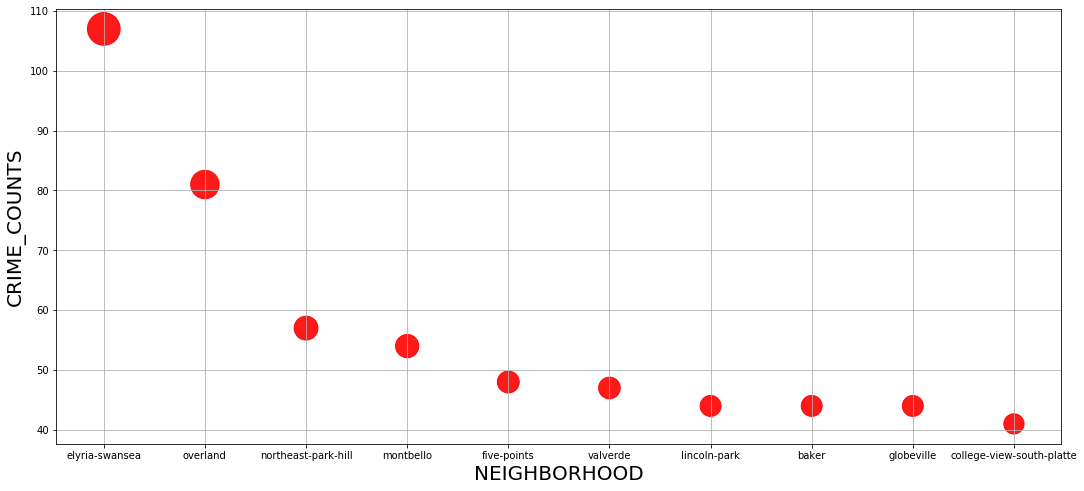

In [17]:
plt.figure(figsize=(18,8))
plt.scatter(top_10.NEIGHBORHOOD_ID,top_10.CRIME_COUNTS, alpha = 0.9, s = 10*(top_10.CRIME_COUNTS), c = 'r', marker = 'o')
plt.xlabel('NEIGHBORHOOD', fontsize = 20)  # Add an x-label to the axes.
plt.ylabel('CRIME_COUNTS', fontsize = 20)  # Add a y-label to the axes.
plt.grid(True)
plt.show()

#### Lets analyze the top 4 neighborhoods, WHY? In the figure we can see that for the bottom 6 neighborhoods, the numbers are almost close to each other, hence,lets analyze the top 4, where more than 50 incidents have been reported. For this we query row wise to find the incident addresses corresponding to the incidents reported in the neighborhood from our original dataframe. 

#### The top 4 neighborhoods are:
        1. elyria-swansea
        2.overland
        3. northeast-park-hill
        4.montbello

In [18]:
crime_marijuana.head()

,INCIDENT_ID,FIRST_OCCURENCE_DATE,LAST_OCCURENCE_DATE,REPORTDATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,DISTRICT_ID,PRECINCT_ID,OFFENSE_CODE,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,MJ_RELATION_TYPE,NEIGHBORHOOD_ID
0,201632070,16-JAN-16,16-JAN-16,16-JAN-16,777 N CANOSA CT,3134946.0,1690779.0,1,122,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r,sun-valley
1,2015229394,27-APR-15,27-APR-15,27-APR-15,20731 E 48TH PL,3212140.0,1710884.0,5,523,2204,BURGLARY - RESIDENCE NO FORCE,Burglary,NON-INDUSTRY\r,gateway-green-valley-ranch
2,2015581938,06-OCT-15,NaN,06-OCT-15,1332 S CHEROKEE ST,3143338.0,1677553.0,3,313,2308,THEFT - FROM BLDG,Larceny,INDUSTRY\r,overland
3,2015439946,02-AUG-15,NaN,03-AUG-15,1201 20TH ST,3142928.0,1699409.0,6,612,1316,THREATS TO INJURE,All Other Crimes,INDUSTRY\r,five-points
4,2016803636,18-DEC-16,NaN,18-DEC-16,1055 S FOX ST,3142161.0,1679300.0,4,412,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r,athmar-park


In [19]:
new_cm = crime_marijuana[['INCIDENT_ADDRESS']]
new_cm.head()

,INCIDENT_ADDRESS
0,777 N CANOSA CT
1,20731 E 48TH PL
2,1332 S CHEROKEE ST
3,1201 20TH ST
4,1055 S FOX ST


In [25]:
nb_m =crime_marijuana.set_index('NEIGHBORHOOD_ID')
nb_m

,INCIDENT_ID,FIRST_OCCURENCE_DATE,LAST_OCCURENCE_DATE,REPORTDATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,DISTRICT_ID,PRECINCT_ID,OFFENSE_CODE,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,MJ_RELATION_TYPE
NEIGHBORHOOD_ID,,,,,,,,,,,,,
sun-valley,201632070,16-JAN-16,16-JAN-16,16-JAN-16,777 N CANOSA CT,3134946.0,1690779.0,1,122,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r
gateway-green-valley-ranch,2015229394,27-APR-15,27-APR-15,27-APR-15,20731 E 48TH PL,3212140.0,1710884.0,5,523,2204,BURGLARY - RESIDENCE NO FORCE,Burglary,NON-INDUSTRY\r
overland,2015581938,06-OCT-15,NaN,06-OCT-15,1332 S CHEROKEE ST,3143338.0,1677553.0,3,313,2308,THEFT - FROM BLDG,Larceny,INDUSTRY\r
five-points,2015439946,02-AUG-15,NaN,03-AUG-15,1201 20TH ST,3142928.0,1699409.0,6,612,1316,THREATS TO INJURE,All Other Crimes,INDUSTRY\r
athmar-park,2016803636,18-DEC-16,NaN,18-DEC-16,1055 S FOX ST,3142161.0,1679300.0,4,412,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r
...,...,...,...,...,...,...,...,...,...,...,...,...,...
belcaro,2019764415,03-DEC-19,NaN,03-DEC-19,399 S HARRISON ST,3157075.0,1683778.0,3,311,1202,ROBBERY - BUSINESS,Robbery-Business,INDUSTRY\r
platt-park,2019796082,18-DEC-19,NaN,18-DEC-19,2020 S BROADWAY ST,3144349.0,1672869.0,3,313,7399,PUBLIC ORDER CRIMES - OTHER,All Other Crimes,INDUSTRY\r
hampden,2019800228,20-DEC-19,20-DEC-19,20-DEC-19,3480 S GALENA ST,3177845.0,1663780.0,3,323,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r


In [28]:
n_m = nb_m.loc[['elyria-swansea','overland','northeast-park-hill','montbello']]
n_m

,INCIDENT_ID,FIRST_OCCURENCE_DATE,LAST_OCCURENCE_DATE,REPORTDATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,DISTRICT_ID,PRECINCT_ID,OFFENSE_CODE,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,MJ_RELATION_TYPE
NEIGHBORHOOD_ID,,,,,,,,,,,,,
elyria-swansea,2015568265,23-SEP-15,29-SEP-15,30-SEP-15,3900 E 48TH AVE,3156932.0,1710798.0,2,212,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r
elyria-swansea,2015280757,22-MAY-15,22-MAY-15,22-MAY-15,3995 E 50TH AVE,3156921.0,1712528.0,2,212,3560,DRUG - MARIJUANA SELL,Drug Offenses,INDUSTRY\r
elyria-swansea,2016571223,05-SEP-16,05-SEP-16,06-SEP-16,5231 N MONROE ST,3155803.0,1714030.0,2,212,2205,BURGLARY - BUSINESS NO FORCE,Burglary,INDUSTRY\r
elyria-swansea,2015725807,14-DEC-15,14-DEC-15,14-DEC-15,3930 BLAKE ST,3148766.0,1706573.0,2,211,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r
elyria-swansea,2019170676,18-MAR-19,18-MAR-19,18-MAR-19,4975 N VASQUEZ BLVD,3155551.0,1711955.0,2,212,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r
...,...,...,...,...,...,...,...,...,...,...,...,...,...
montbello,2016515474,14-AUG-16,14-AUG-16,14-AUG-16,4700 N KINGSTON ST,3180286.0,1710621.0,5,511,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r
montbello,2017711025,23-OCT-17,23-OCT-17,23-OCT-17,5015 N TUCSON WAY,3185158.0,1712375.0,5,521,1208,ROBBERY - RESIDENCE,Robbery-Street-Res,NON-INDUSTRY\r
montbello,2018552069,13-AUG-18,NaN,13-AUG-18,4620 N PEORIA ST,3183815.0,1709739.0,5,521,5707,CRIMINAL TRESPASSING,All Other Crimes,INDUSTRY\r


In [27]:
n_m.shape

(299, 13)

In [29]:
add1 = '5141 N Franklin Street, Denver, CO'

#### Since there are multiple addresses for each neighborhood, we would arbitrarily select one of them for location. 

In [30]:
n_m = nb_m.loc[['overland','northeast-park-hill','montbello']]
n_m

,INCIDENT_ID,FIRST_OCCURENCE_DATE,LAST_OCCURENCE_DATE,REPORTDATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,DISTRICT_ID,PRECINCT_ID,OFFENSE_CODE,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,MJ_RELATION_TYPE
NEIGHBORHOOD_ID,,,,,,,,,,,,,
overland,2015581938,06-OCT-15,NaN,06-OCT-15,1332 S CHEROKEE ST,3143338.0,1677553.0,3,313,2308,THEFT - FROM BLDG,Larceny,INDUSTRY\r
overland,201577748,09-FEB-15,09-FEB-15,09-FEB-15,1994 S CHEROKEE ST,3143266.0,1673126.0,3,313,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r
overland,2015166696,26-MAR-15,27-MAR-15,27-MAR-15,1101 S BANNOCK ST,3143377.0,1678960.0,3,313,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r
overland,2018520245,01-AUG-18,01-AUG-18,01-AUG-18,1911 S BROADWAY ST,3144086.0,1673620.0,3,313,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r
overland,2018272817,24-APR-18,24-APR-18,24-APR-18,2645 S SANTA FE DR,3141742.0,1668660.0,3,313,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r
...,...,...,...,...,...,...,...,...,...,...,...,...,...
montbello,2016515474,14-AUG-16,14-AUG-16,14-AUG-16,4700 N KINGSTON ST,3180286.0,1710621.0,5,511,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r
montbello,2017711025,23-OCT-17,23-OCT-17,23-OCT-17,5015 N TUCSON WAY,3185158.0,1712375.0,5,521,1208,ROBBERY - RESIDENCE,Robbery-Street-Res,NON-INDUSTRY\r
montbello,2018552069,13-AUG-18,NaN,13-AUG-18,4620 N PEORIA ST,3183815.0,1709739.0,5,521,5707,CRIMINAL TRESPASSING,All Other Crimes,INDUSTRY\r


In [32]:
add2 = '1755 S Broadway Street, Denver, CO'

In [31]:
n_m = nb_m.loc[['northeast-park-hill','montbello']]
n_m

,INCIDENT_ID,FIRST_OCCURENCE_DATE,LAST_OCCURENCE_DATE,REPORTDATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,DISTRICT_ID,PRECINCT_ID,OFFENSE_CODE,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,MJ_RELATION_TYPE
NEIGHBORHOOD_ID,,,,,,,,,,,,,
northeast-park-hill,2016420936,03-JUL-16,04-JUL-16,04-JUL-16,3880 N HOLLY ST,3162502.0,1706158.0,2,221,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r
northeast-park-hill,2016506158,09-AUG-16,10-AUG-16,10-AUG-16,3925 N ONEIDA ST,3166405.0,1706487.0,2,221,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r
northeast-park-hill,2016666072,17-OCT-16,17-OCT-16,17-OCT-16,5000 E 41ST AVE,3160305.0,1706930.0,2,221,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r
northeast-park-hill,2016344743,02-JUN-16,NaN,02-JUN-16,3955 N ONEIDA ST,3166432.0,1706593.0,2,221,2303,THEFT - SHOPLIFT,Larceny,INDUSTRY\r
northeast-park-hill,2019334193,29-MAY-19,29-MAY-19,29-MAY-19,5000 E 41ST AVE,3160362.0,1706982.0,2,221,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r
...,...,...,...,...,...,...,...,...,...,...,...,...,...
montbello,2016515474,14-AUG-16,14-AUG-16,14-AUG-16,4700 N KINGSTON ST,3180286.0,1710621.0,5,511,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r
montbello,2017711025,23-OCT-17,23-OCT-17,23-OCT-17,5015 N TUCSON WAY,3185158.0,1712375.0,5,521,1208,ROBBERY - RESIDENCE,Robbery-Street-Res,NON-INDUSTRY\r
montbello,2018552069,13-AUG-18,NaN,13-AUG-18,4620 N PEORIA ST,3183815.0,1709739.0,5,521,5707,CRIMINAL TRESPASSING,All Other Crimes,INDUSTRY\r


In [33]:
add3 = '4401 E 46th Avenue, Denver CO'

In [34]:
add4 = '4750 N Nome Street, Denver, CO'

### Define Foursquare Credentials and Version

In [35]:
CLIENT_ID = '4DWXXKPYMWUDXWLFHCHRIWR1QL5XM5EWPNHHOTFXTHWTTTCS' # your Foursquare ID
CLIENT_SECRET = 'MRXWZNHFDJTO2OORDFS4QJQZDKG0OTUSNNWOTCZK45WDN4PI' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID:' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID:4DWXXKPYMWUDXWLFHCHRIWR1QL5XM5EWPNHHOTFXTHWTTTCS
CLIENT_SECRET:MRXWZNHFDJTO2OORDFS4QJQZDKG0OTUSNNWOTCZK45WDN4PI


#### let's start by converting the addresses to its latitude and longitude coordinates.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>foursquare_agent</em>, as shown below.

In [36]:
# for northeast-park-hill
add3 = '4401 E 46th Avenue, Denver CO'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(add3)
lat3 = location.latitude
long3 = location.longitude
print(lat3, long3)

39.7800173 -104.959312


In [37]:
# for montbello
add4 = '4750 N Nome Street, Denver, CO'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(add4)
lat4 = location.latitude
long4 = location.longitude
print(lat4, long4)

AttributeError: 'NoneType' object has no attribute 'latitude'

#### Geocoder did not work for this address, so I used google maps. 

In [38]:
# for elyria-swansea
lat1 = 39.790
long1 = -104.968

In [39]:
# for overland
lat2 = 39.684
long2 = -104.9877

In [40]:
# for montbello
lat4 = 39.783736
long4 = -104.851970

<a id="item1"></a>

## Now we search for Marijuana businesses near these venues
> `https://api.foursquare.com/v2/venues/`**search**`?client_id=`**CLIENT_ID**`&client_secret=`**CLIENT_SECRET**`&ll=`**LATITUDE**`,`**LONGITUDE**`&v=`**VERSION**`&query=`**QUERY**`&radius=`**RADIUS**`&limit=`**LIMIT**

#### Now, let's get a JSON file for the Denver metropolitan area and mark these neighborhoods first, with a radius of 50 km for every marijuana stores around

In [41]:
search_query = 'Marijuana'
radius = 50000
print(search_query + ' .... OK!')

Marijuana .... OK!


#### Define the corresponding URL

In [42]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, 39.7479, -104.994616, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=4DWXXKPYMWUDXWLFHCHRIWR1QL5XM5EWPNHHOTFXTHWTTTCS&client_secret=MRXWZNHFDJTO2OORDFS4QJQZDKG0OTUSNNWOTCZK45WDN4PI&ll=39.7479,-104.994616&v=20180604&query=Marijuana&radius=50000&limit=30'

#### Send the GET Request and examine the results

In [43]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e8e309477af03001b4dca1d'},
 'response': {'venues': [{'id': '56e12916498e4cb484cc0b80',
    'name': 'Marijuana Consulting Of Denver',
    'location': {'address': '1550 Larimer St #675',
     'lat': 39.74921922145835,
     'lng': -104.99661684036255,
     'labeledLatLngs': [{'label': 'display',
       'lat': 39.74921922145835,
       'lng': -104.99661684036255}],
     'distance': 225,
     'postalCode': '80202',
     'cc': 'US',
     'city': 'Denver',
     'state': 'CO',
     'country': 'United States',
     'formattedAddress': ['1550 Larimer St #675',
      'Denver, CO 80202',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d1ff941735',
      'name': 'Miscellaneous Shop',
      'pluralName': 'Miscellaneous Shops',
      'shortName': 'Shop',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/default_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1586376805',
    'hasPerk': False},
   {

#### Get relevant part of JSON and transform it into a *pandas* dataframe

In [44]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = pd.json_normalize(venues)
dataframe.head()

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet,venuePage.id
0,56e12916498e4cb484cc0b80,Marijuana Consulting Of Denver,"[{'id': '4bf58dd8d48988d1ff941735', 'name': 'M...",v-1586376805,False,1550 Larimer St #675,39.749219,-104.996617,"[{'label': 'display', 'lat': 39.74921922145835...",225,80202,US,Denver,CO,United States,"[1550 Larimer St #675, Denver, CO 80202, Unite...",NaN,NaN
1,5a8e1dabc824ae18988f271e,The Green Solution Recreational Marijuana Disp...,"[{'id': '52c71aaf3cf9994f4e043d17', 'name': 'M...",v-1586376805,False,1995 Wewatta St,39.756676,-104.998004,"[{'label': 'display', 'lat': 39.756676, 'lng':...",1019,80202,US,Denver,CO,United States,"[1995 Wewatta St (20th & Wewatta), Denver, CO ...",20th & Wewatta,NaN
2,4d1104d471e8a1cd535c84bd,MMD Medical Doctors - Medical Marijuana Red Ca...,"[{'id': '52c71aaf3cf9994f4e043d17', 'name': 'M...",v-1586376805,False,"450 Lincoln St, Suite 104",39.723414,-104.985877,"[{'label': 'display', 'lat': 39.7234139, 'lng'...",2826,80203,US,Denver,CO,United States,"[450 Lincoln St, Suite 104 (4th and Lincoln), ...",4th and Lincoln,NaN
3,518017ef498e1a2420fc5255,Marijuana Enforcement Division,"[{'id': '4bf58dd8d48988d124941735', 'name': 'O...",v-1586376805,False,NaN,39.723381,-104.985250,"[{'label': 'display', 'lat': 39.72338071475686...",2844,NaN,US,Denver,CO,United States,"[Denver, CO, United States]",NaN,NaN
4,58c759e5951e7d768e1013a8,Marijuana Marketing Gurus,"[{'id': '52e81612bcbc57f1066b7a3d', 'name': 'A...",v-1586376805,False,940 N Lincoln St #106,39.731213,-104.985825,"[{'label': 'display', 'lat': 39.7312131, 'lng'...",2004,80203,US,Denver,CO,United States,"[940 N Lincoln St #106, Denver, CO 80203, Unit...",NaN,NaN


#### Define information of interest and filter dataframe

In [45]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,id
0,Marijuana Consulting Of Denver,Miscellaneous Shop,1550 Larimer St #675,39.749219,-104.996617,"[{'label': 'display', 'lat': 39.74921922145835...",225,80202,US,Denver,CO,United States,"[1550 Larimer St #675, Denver, CO 80202, Unite...",NaN,56e12916498e4cb484cc0b80
1,The Green Solution Recreational Marijuana Disp...,Marijuana Dispensary,1995 Wewatta St,39.756676,-104.998004,"[{'label': 'display', 'lat': 39.756676, 'lng':...",1019,80202,US,Denver,CO,United States,"[1995 Wewatta St (20th & Wewatta), Denver, CO ...",20th & Wewatta,5a8e1dabc824ae18988f271e
2,MMD Medical Doctors - Medical Marijuana Red Ca...,Marijuana Dispensary,"450 Lincoln St, Suite 104",39.723414,-104.985877,"[{'label': 'display', 'lat': 39.7234139, 'lng'...",2826,80203,US,Denver,CO,United States,"[450 Lincoln St, Suite 104 (4th and Lincoln), ...",4th and Lincoln,4d1104d471e8a1cd535c84bd
3,Marijuana Enforcement Division,Office,NaN,39.723381,-104.985250,"[{'label': 'display', 'lat': 39.72338071475686...",2844,NaN,US,Denver,CO,United States,"[Denver, CO, United States]",NaN,518017ef498e1a2420fc5255
4,Marijuana Marketing Gurus,Advertising Agency,940 N Lincoln St #106,39.731213,-104.985825,"[{'label': 'display', 'lat': 39.7312131, 'lng'...",2004,80203,US,Denver,CO,United States,"[940 N Lincoln St #106, Denver, CO 80203, Unit...",NaN,58c759e5951e7d768e1013a8
5,LivWell Enlightened Health Marijuana Dispensary,Alternative Healer,2863 Larimer St,39.761350,-104.981960,"[{'label': 'display', 'lat': 39.76135, 'lng': ...",1847,80205,US,Denver,CO,United States,"[2863 Larimer St, Denver, CO 80205, United Sta...",NaN,5324284a498e5604297f30bb
6,Discount Medical Marijuana,Marijuana Dispensary,970 N Lincoln St,39.731665,-104.986082,"[{'label': 'display', 'lat': 39.73166545, 'lng...",1949,80203,US,Denver,CO,United States,"[970 N Lincoln St (10th Ave.), Denver, CO 8020...",10th Ave.,4c87f9cf72b1236ab7bd7236
7,Peak - Marijuana Dispensary,Alternative Healer,260 Broadway,39.728855,-104.993460,"[{'label': 'display', 'lat': 39.72885508307662...",2122,80203,US,Denver,CO,United States,"[260 Broadway (3rd Ave), Denver, CO 80203, Uni...",3rd Ave,54703830498e4b0524730831
8,Medical Marijuana Licensing Agency,Government Building,NaN,39.830450,-104.919998,"[{'label': 'display', 'lat': 39.83045, 'lng': ...",11188,NaN,US,NaN,Colorado,United States,"[Colorado, United States]",NaN,4e52a428d1643fe9163de1d3
9,Colorado Medical Marijuana Enforcement Division,Government Building,455 Sherman St Are 390,39.723543,-104.985193,"[{'label': 'display', 'lat': 39.72354328634907...",2828,80224,US,Denver,CO,United States,"[455 Sherman St Are 390 (5th And Sherman), Den...",5th And Sherman,4e67837b14952e0a12ea1747


#### Let's visualize the places related to Marijuana business that are nearby

In [46]:
dataframe_filtered.name

0                        Marijuana Consulting Of Denver
1     The Green Solution Recreational Marijuana Disp...
2     MMD Medical Doctors - Medical Marijuana Red Ca...
3                        Marijuana Enforcement Division
4                             Marijuana Marketing Gurus
5       LivWell Enlightened Health Marijuana Dispensary
6                            Discount Medical Marijuana
7                          Peak -  Marijuana Dispensary
8                    Medical Marijuana Licensing Agency
9       Colorado Medical Marijuana Enforcement Division
10                           Discount Medical Marijuana
11                        MMD Medical Marijuana Doctors
12    Colorado Department of Revenue Medicinal Marij...
13    Buddy Boy Brands | Medical Marijuana and Recre...
14                           Discount Medical Marijuana
15                     Denver Marijuana Medical  Center
16    Caregivers For Life Recreational & Medical Mar...
17                                     Marijuana

In [47]:
df_new= dataframe_filtered[['name','categories','lat','lng']]
df_new

,name,categories,lat,lng
0,Marijuana Consulting Of Denver,Miscellaneous Shop,39.749219,-104.996617
1,The Green Solution Recreational Marijuana Disp...,Marijuana Dispensary,39.756676,-104.998004
2,MMD Medical Doctors - Medical Marijuana Red Ca...,Marijuana Dispensary,39.723414,-104.985877
3,Marijuana Enforcement Division,Office,39.723381,-104.985250
4,Marijuana Marketing Gurus,Advertising Agency,39.731213,-104.985825
5,LivWell Enlightened Health Marijuana Dispensary,Alternative Healer,39.761350,-104.981960
6,Discount Medical Marijuana,Marijuana Dispensary,39.731665,-104.986082
7,Peak - Marijuana Dispensary,Alternative Healer,39.728855,-104.993460
8,Medical Marijuana Licensing Agency,Government Building,39.830450,-104.919998
9,Colorado Medical Marijuana Enforcement Division,Government Building,39.723543,-104.985193


In [92]:
venues_map = folium.Map(location=[39.7479, -104.994616]) 

# add a red circle marker to represent the neighborhoods
folium.features.CircleMarker(
    [lat1, long1],
    radius=10,
    color='red',
    popup='Elyria-swansea',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

folium.features.CircleMarker(
    [lat2, long2],
    radius=10,
    color='red',
    popup='Overland',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

folium.features.CircleMarker(
    [lat3, long3],
    radius=10,
    color='red',
    popup='Northeast-park-hill',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

folium.features.CircleMarker(
    [lat4, long4],
    radius=10,
    color='red',
    popup='Montbello',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)
venues_map

for i in range(0,len(df_new)):
    folium.Marker([df_new.iloc[i]['lat'], df_new.iloc[i]['lng']], popup=df_new.iloc[i]['name']).add_to(venues_map)

venues_map

 ### Now we will try to see if there are distinct clusters of marijuana shops in Denver metropolitan area and if the centroid of these clusters coincide with any of the four top neighborhood centers of crime reported for marijuana related incidents? We will use K-Means clustering for this

<a id="item2"></a>

### Importing libraries

In [49]:
import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 

from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

print('Libraries imported.')

Libraries imported.


In [50]:
X = df_new.values[:,2:]
X

array([[39.74921922145835, -104.99661684036255],
       [39.756676, -104.99800400000001],
       [39.7234139, -104.9858772],
       [39.723380714756864, -104.98524961513837],
       [39.7312131, -104.9858247],
       [39.76135, -104.98196],
       [39.73166545, -104.98608201666667],
       [39.728855083076624, -104.99345995325444],
       [39.83045, -104.9199976],
       [39.72354328634907, -104.98519256074492],
       [39.72558838783306, -104.98786843357733],
       [39.723131352645694, -104.98729348182677],
       [39.723630345811515, -104.9872921757532],
       [39.769452, -105.02087],
       [39.739739, -104.96261799999999],
       [39.760828, -105.025717],
       [39.721342, -104.95071599999999],
       [39.67136037479607, -104.99225604843029],
       [39.7365837097168, -104.98136138916016],
       [39.74250431287842, -104.95343327522276],
       [39.7783401182429, -104.97860861970315],
       [39.772706, -104.967982],
       [39.715645, -104.988998],
       [39.7776, -104.97003],

In [51]:
num_clusters = 5

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(X)
labels = k_means.labels_

print(labels)

[3 3 1 1 1 3 1 1 0 1 1 1 1 2 1 2 1 4 1 1 3 3 1 3 4 1 1 2 2 2]


In [52]:
df_new["Labels"] = labels
df_new

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,name,categories,lat,lng,Labels
0,Marijuana Consulting Of Denver,Miscellaneous Shop,39.749219,-104.996617,3
1,The Green Solution Recreational Marijuana Disp...,Marijuana Dispensary,39.756676,-104.998004,3
2,MMD Medical Doctors - Medical Marijuana Red Ca...,Marijuana Dispensary,39.723414,-104.985877,1
3,Marijuana Enforcement Division,Office,39.723381,-104.985250,1
4,Marijuana Marketing Gurus,Advertising Agency,39.731213,-104.985825,1
5,LivWell Enlightened Health Marijuana Dispensary,Alternative Healer,39.761350,-104.981960,3
6,Discount Medical Marijuana,Marijuana Dispensary,39.731665,-104.986082,1
7,Peak - Marijuana Dispensary,Alternative Healer,39.728855,-104.993460,1
8,Medical Marijuana Licensing Agency,Government Building,39.830450,-104.919998,0
9,Colorado Medical Marijuana Enforcement Division,Government Building,39.723543,-104.985193,1


### Some of them are dropped because they are government buildings and parks, not vendors

In [66]:
df_nnew = df_new.drop([3,7,4,11,17,18,28,21,14,12,22,27,19,8])
df_nnew

,name,categories,lat,lng,Labels
0,Marijuana Consulting Of Denver,Miscellaneous Shop,39.749219,-104.996617,3
1,The Green Solution Recreational Marijuana Disp...,Marijuana Dispensary,39.756676,-104.998004,3
2,MMD Medical Doctors - Medical Marijuana Red Ca...,Marijuana Dispensary,39.723414,-104.985877,1
5,LivWell Enlightened Health Marijuana Dispensary,Alternative Healer,39.761350,-104.981960,3
6,Discount Medical Marijuana,Marijuana Dispensary,39.731665,-104.986082,1
9,Colorado Medical Marijuana Enforcement Division,Government Building,39.723543,-104.985193,1
10,Discount Medical Marijuana,Marijuana Dispensary,39.725588,-104.987868,1
13,Buddy Boy Brands | Medical Marijuana and Recre...,Marijuana Dispensary,39.769452,-105.020870,2
15,Denver Marijuana Medical Center,Marijuana Dispensary,39.760828,-105.025717,2
16,Caregivers For Life Recreational & Medical Mar...,Marijuana Dispensary,39.721342,-104.950716,1


In [67]:
X = df_nnew.values[:,2:4]
X

array([[39.74921922145835, -104.99661684036255],
       [39.756676, -104.99800400000001],
       [39.7234139, -104.9858772],
       [39.76135, -104.98196],
       [39.73166545, -104.98608201666667],
       [39.72354328634907, -104.98519256074492],
       [39.72558838783306, -104.98786843357733],
       [39.769452, -105.02087],
       [39.760828, -105.025717],
       [39.721342, -104.95071599999999],
       [39.7783401182429, -104.97860861970315],
       [39.7776, -104.97003],
       [39.679085, -105.010617],
       [39.73700063, -104.99343805],
       [39.7005115, -104.9388298],
       [39.747192999999996, -105.063024]], dtype=object)

In [68]:
num_clusters = 5

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(X)
labels = k_means.labels_

print(labels)

[2 0 2 0 2 2 2 3 3 4 0 0 1 2 4 3]


In [69]:
df_nnew["Labels"] = labels
df_nnew

,name,categories,lat,lng,Labels
0,Marijuana Consulting Of Denver,Miscellaneous Shop,39.749219,-104.996617,2
1,The Green Solution Recreational Marijuana Disp...,Marijuana Dispensary,39.756676,-104.998004,0
2,MMD Medical Doctors - Medical Marijuana Red Ca...,Marijuana Dispensary,39.723414,-104.985877,2
5,LivWell Enlightened Health Marijuana Dispensary,Alternative Healer,39.761350,-104.981960,0
6,Discount Medical Marijuana,Marijuana Dispensary,39.731665,-104.986082,2
9,Colorado Medical Marijuana Enforcement Division,Government Building,39.723543,-104.985193,2
10,Discount Medical Marijuana,Marijuana Dispensary,39.725588,-104.987868,2
13,Buddy Boy Brands | Medical Marijuana and Recre...,Marijuana Dispensary,39.769452,-105.020870,3
15,Denver Marijuana Medical Center,Marijuana Dispensary,39.760828,-105.025717,3
16,Caregivers For Life Recreational & Medical Mar...,Marijuana Dispensary,39.721342,-104.950716,4


In [70]:
centroids= df_nnew.groupby('Labels').mean()
centroids

,lat,lng
Labels,,
0,39.768492,-104.982151
1,39.679085,-105.010617
2,39.731738,-104.989179
3,39.759158,-105.036537
4,39.710927,-104.944773


In [71]:
for i in range(0,len(centroids)):
    folium.CircleMarker([centroids.iloc[i]['lat'], centroids.iloc[i]['lng']], color = 'yellow', fill = True, fill_color = 'black',fill_opacity = 0.6).add_to(venues_map)
    
venues_map

#### Now running K-means again with 4 clusters

In [72]:
X = df_nnew.values[:,2:4]
X

array([[39.74921922145835, -104.99661684036255],
       [39.756676, -104.99800400000001],
       [39.7234139, -104.9858772],
       [39.76135, -104.98196],
       [39.73166545, -104.98608201666667],
       [39.72354328634907, -104.98519256074492],
       [39.72558838783306, -104.98786843357733],
       [39.769452, -105.02087],
       [39.760828, -105.025717],
       [39.721342, -104.95071599999999],
       [39.7783401182429, -104.97860861970315],
       [39.7776, -104.97003],
       [39.679085, -105.010617],
       [39.73700063, -104.99343805],
       [39.7005115, -104.9388298],
       [39.747192999999996, -105.063024]], dtype=object)

In [73]:
num_clusters = 4

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(X)
labels = k_means.labels_

print(labels)

[1 1 0 1 0 0 0 2 2 3 1 1 0 0 3 2]


In [74]:
df_nnew["Labels"] = labels
df_nnew

,name,categories,lat,lng,Labels
0,Marijuana Consulting Of Denver,Miscellaneous Shop,39.749219,-104.996617,1
1,The Green Solution Recreational Marijuana Disp...,Marijuana Dispensary,39.756676,-104.998004,1
2,MMD Medical Doctors - Medical Marijuana Red Ca...,Marijuana Dispensary,39.723414,-104.985877,0
5,LivWell Enlightened Health Marijuana Dispensary,Alternative Healer,39.761350,-104.981960,1
6,Discount Medical Marijuana,Marijuana Dispensary,39.731665,-104.986082,0
9,Colorado Medical Marijuana Enforcement Division,Government Building,39.723543,-104.985193,0
10,Discount Medical Marijuana,Marijuana Dispensary,39.725588,-104.987868,0
13,Buddy Boy Brands | Medical Marijuana and Recre...,Marijuana Dispensary,39.769452,-105.020870,2
15,Denver Marijuana Medical Center,Marijuana Dispensary,39.760828,-105.025717,2
16,Caregivers For Life Recreational & Medical Mar...,Marijuana Dispensary,39.721342,-104.950716,3


In [75]:
centroids= df_nnew.groupby('Labels').mean()
centroids

,lat,lng
Labels,,
0,39.720049,-104.991513
1,39.764637,-104.985044
2,39.759158,-105.036537
3,39.710927,-104.944773


In [78]:
for i in range(0,len(centroids)):
    folium.CircleMarker([centroids.iloc[i]['lat'], centroids.iloc[i]['lng']], color = 'yellow', fill = True, fill_color = 'black',fill_opacity = 0.6).add_to(venues_map)
    
venues_map

### This does not look better than the previous result, hence 5 clusters is better. However, the decision should be made on minimizing the distortions and inertia. Sol lets define those terms and see what should be the best number of clusters. 

#### We now define the following:-

Distortion: It is calculated as the average of the squared distances from the cluster centers of the respective clusters. Typically, the Euclidean distance metric is used.

Inertia: It is the sum of squared distances of samples to their closest cluster center

In [80]:
X = df_nnew.values[:,2:4]
X

array([[39.74921922145835, -104.99661684036255],
       [39.756676, -104.99800400000001],
       [39.7234139, -104.9858772],
       [39.76135, -104.98196],
       [39.73166545, -104.98608201666667],
       [39.72354328634907, -104.98519256074492],
       [39.72558838783306, -104.98786843357733],
       [39.769452, -105.02087],
       [39.760828, -105.025717],
       [39.721342, -104.95071599999999],
       [39.7783401182429, -104.97860861970315],
       [39.7776, -104.97003],
       [39.679085, -105.010617],
       [39.73700063, -104.99343805],
       [39.7005115, -104.9388298],
       [39.747192999999996, -105.063024]], dtype=object)

In [82]:
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import numpy as np

In [83]:
# lets create a loop which runs for different Ks (1 to 6) and return the distortions and Inertias
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,6) 

for k in K: 
	#Building and fitting the model 
	kmeanModel = KMeans(n_clusters=k).fit(X) 
	kmeanModel.fit(X)	 
	
	distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
					'euclidean'),axis=1)) / X.shape[0]) 
	inertias.append(kmeanModel.inertia_) 

	mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
				'euclidean'),axis=1)) / X.shape[0] 
	mapping2[k] = kmeanModel.inertia_ 

In [84]:
for key,val in mapping1.items(): 
	print(str(key)+' : '+str(val)) 

1 : 0.03296670504965218
2 : 0.02522467002371315
3 : 0.020134622723368606
4 : 0.015763104134778178
5 : 0.011781733867003444


## Insight

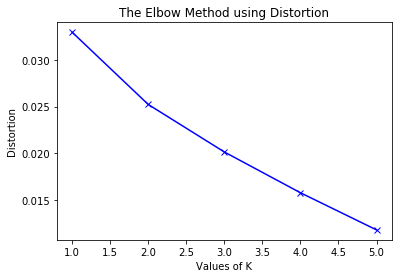

In [85]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

#### the figure does not seem to have an obvious elbow. However, 2 looks something like an elbow

1 : 0.02435606627264478
2 : 0.013916925812001418
3 : 0.008888993296132686
4 : 0.005487266610685779
5 : 0.0030041078537442678


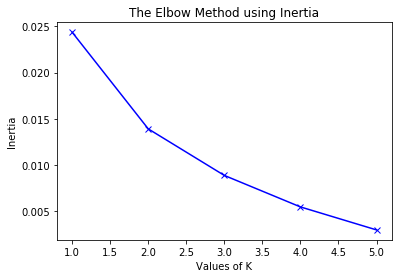

In [87]:
# Lets look at inertias
for key,val in mapping2.items(): 
	print(str(key)+' : '+str(val)) 
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

### A little more pronounced and it seems to be really 2 , so lets plot the result of two clusters on the map

In [93]:
X = df_nnew.values[:,2:4]

num_clusters = 2

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(X)
labels = k_means.labels_

df_nnew["Labels"] = labels
df_nnew

centroids= df_nnew.groupby('Labels').mean()
centroids

for i in range(0,len(centroids)):
    folium.CircleMarker([centroids.iloc[i]['lat'], centroids.iloc[i]['lng']], color = 'yellow', fill = True, fill_color = 'black',fill_opacity = 0.6).add_to(venues_map)
    
venues_map

##### The cluster of stores near the downtown are dense and much safer than the stores in elyria Swansea and towards south broadway and University of Denver campus. It is really difficult to tell anything about the safety of people who go to buy medical or recreational marijuana in Montbello neighborhood because of lack of data. The stores in the Edgewater and Glendale neighborhood are quite in good numbers and certainly safer and less crime related to marijuana reported there. 

Hence, for new stores and customers of medical or recreational marijuana, new businesses opportunities lies safer in Denver downtown (for obvious reasons), however, Edgewater and Glendale neighborhood seems safer too and probably cheaper to rent a business there than Denver downtown (can't be established using the data presented in this study, but a general decrease in property value going away from downtown is expected).

### Thank you for going through this notebook! This is my first exposure to any Machine learning project implementation. I hope you found the study interesting, However, there is just so much more that could have been done to make the study better, but that would definitely take a plenty of time.....in terms of data collection and trying out new ideas and iterating through them.  If you did connect with me on Linkedin. 

This notebook was created by Suman Saurabh. (https://www.linkedin.com/in/suman-saurabh-10155b198/).